# Incremental capstone 10: face mask detection

## References

This notebook implements a convolutional neural network for face mask detection using established architectural and training strategies from the deep learning literature:

**Architecture:**
- **3×3 Convolution Kernels**: Simonyan & Zisserman (2015) demonstrated in VGGNet that stacking small 3×3 kernels is more effective than larger kernels, providing the same receptive field with fewer parameters and more non-linearity. *"Very Deep Convolutional Networks for Large-Scale Image Recognition"* [[arXiv:1409.1556](https://arxiv.org/abs/1409.1556)]
- **Batch Normalization**: Ioffe & Szegedy (2015) introduced batch normalization to stabilize training, reduce internal covariate shift, and enable higher learning rates. *"Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"* [[arXiv:1502.03167](https://arxiv.org/abs/1502.03167)]
- **Dropout Regularization**: Srivastava et al. (2014) showed that dropout prevents co-adaptation of features and reduces overfitting in neural networks. *"Dropout: A Simple Way to Prevent Neural Networks from Overfitting"* Journal of Machine Learning Research 15(56):1929-1958 [[JMLR](https://jmlr.org/papers/v15/srivastava14a.html)]
- **Global Average Pooling**: Lin et al. (2014) proposed global average pooling as an alternative to fully connected layers, reducing parameters and acting as a structural regularizer. *"Network In Network"* [[arXiv:1312.4400](https://arxiv.org/abs/1312.4400)]

**Training Strategies:**
- **Adam Optimizer**: Kingma & Ba (2015) introduced Adam, combining the benefits of adaptive learning rates and momentum for efficient optimization. *"Adam: A Method for Stochastic Optimization"* [[arXiv:1412.6980](https://arxiv.org/abs/1412.6980)]
- **Cyclical Learning Rates**: Smith (2017) introduced cyclical learning rates that vary the learning rate between reasonable bounds during training, eliminating the need to find a single best learning rate and enabling faster convergence. *"Cyclical Learning Rates for Training Neural Networks"* [[arXiv:1506.01186](https://arxiv.org/abs/1506.01186)]
- **Learning Rate Scheduling**: When validation loss plateaus, reducing the learning rate allows for finer-grained weight updates, reducing oscillations and enabling more precise convergence. ReduceLROnPlateau implements this adaptive strategy to improve final model performance.
- **Early Stopping**: Prechelt (1998) formalized early stopping as a regularization technique to prevent overfitting by monitoring validation performance. *"Early Stopping - But When?"* Neural Networks: Tricks of the Trade, Springer [[DOI](https://doi.org/10.1007/3-540-49430-8_3)]
- **Data Augmentation**: Simard et al. (2003) and Krizhevsky et al. (2012) demonstrated that augmentation (rotations, flips, color jitter, etc.) significantly improves generalization by artificially expanding the training set. *"ImageNet Classification with Deep Convolutional Neural Networks"* [[NeurIPS 2012](https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html)]

## 1. Notebook set-up

### 1.1. Imports

In [1]:
# Standard library imports
import os
import warnings

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch import nn
from torch import optim
from torchvision import datasets, transforms

from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# Import custom functions from functions.py
from functions import convert_to_rgb, plot_image_grid, evaluate, train_model, generate_augmented_data

### 1.2. Configuration

In [2]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Data augmentation
force_reaugment = False # Set to True to force regeneration of augmented data even if saved data exists
augmented_data_path = '../data/augmented_train_data.pt' # Path to save/load augmented data

Using device: cuda


### 1.3. Hyperparameters

In [3]:
# Define class names
class_names = ['with_mask', 'without_mask']

augmentations_per_image = 20  # Number of augmentations to generate per original image
batch_size = 32               # Images per batch for training
step_size_up = 2987           # Number of training iterations in a half cycle
epochs = 50                   # Maximum epochs to run
print_every = 5               # Print training progress every n epochs

# Scheduled learning rate bounds (decrease over 50 epochs)
initial_max_lr = 1e-2         # Initial maximum LR
initial_base_lr = 1e-4        # Initial base LR
final_max_lr = 1e-7           # Final maximum LR at epoch 50
final_base_lr = 9.9e-8        # Final base LR at epoch 50
lr_schedule_epochs = 10       # Number of epochs over which to reduce LR bounds

# Early stopping
early_stopping_patience = 10   # Stop training if validation loss doesn't improve for this many epochs

# Calculate batches per epoch (will be determined after data loading)
train_size = 4553
augmented_train_size = train_size * (1 + augmentations_per_image)
batches_per_epoch = augmented_train_size // batch_size

print(f'Augmentation factor: {1 + augmentations_per_image}x')
print(f'Training samples (after augmentation): {augmented_train_size:,}')
print(f'Batches per epoch: {batches_per_epoch:,}')
print(f'Training iterations per cycle: {2 * step_size_up:,}')
print(f'Epochs per cycle: {2 * step_size_up / batches_per_epoch:.1f}')

Augmentation factor: 21x
Training samples (after augmentation): 95,613
Batches per epoch: 2,987
Training iterations per cycle: 5,974
Epochs per cycle: 2.0


## 2. Data preparation

### 2.1. Data exploration

#### Size and composition

In [4]:
# Load dataset to get information
info_dataset = datasets.ImageFolder(root='../data')

# Total number of images
total_images = len(info_dataset)
print(f'Total number of images: {total_images}')

# Collect class frequencies and image dimensions in a single iteration
class_counts = {}
widths = []
heights = []

for img_path, label in info_dataset.imgs:
    class_counts[label] = class_counts.get(label, 0) + 1
    img = Image.open(img_path)
    widths.append(img.width)
    heights.append(img.height)

print('\nRelative class frequencies:')

for label, count in sorted(class_counts.items()):
    relative_freq = count / total_images
    print(f'  {class_names[label]}: {count} images ({relative_freq:.2%})')

Total number of images: 7553

Relative class frequencies:
  with_mask: 3725 images (49.32%)
  without_mask: 3828 images (50.68%)


#### Image dimensions

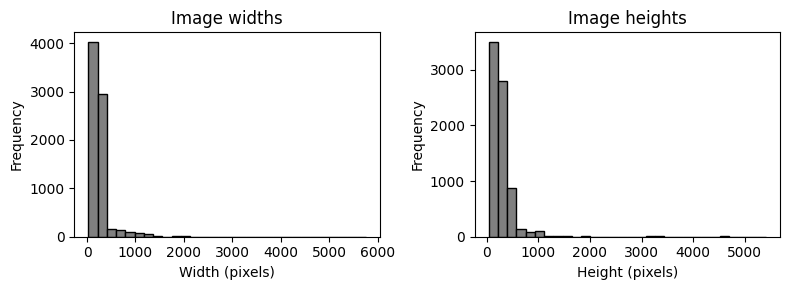

In [5]:
# Plot histograms of image dimensions
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Width histogram
axes[0].set_title('Image widths')
axes[0].hist(widths, bins=30, color='grey', edgecolor='black')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')

# Height histogram
axes[1].set_title('Image heights')
axes[1].hist(heights, bins=30, color='grey', edgecolor='black')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Found 33 images with at least one dimension > 2000 pixels



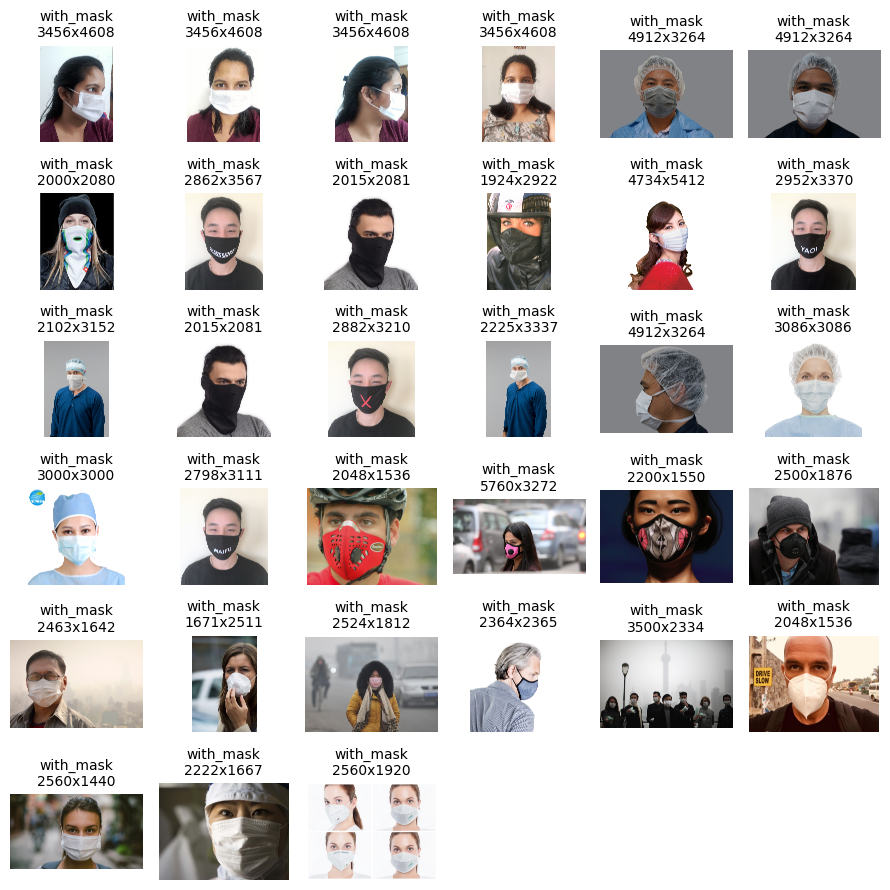

In [6]:
# Find and display images with dimension > 2000 pixels
large_images = []

for idx, (img_path, label) in enumerate(info_dataset.imgs):
    if widths[idx] > 2000 or heights[idx] > 2000:
        large_images.append((img_path, label, widths[idx], heights[idx]))

print(f'Found {len(large_images)} images with at least one dimension > 2000 pixels\n')

if large_images:
    plot_image_grid(
        large_images,
        title_func=lambda data: f'{class_names[data[1]]}\n{data[2]}x{data[3]}'
    )
else:
    print('No images found with dimensions > 2000 pixels')

#### Image aspect ratios

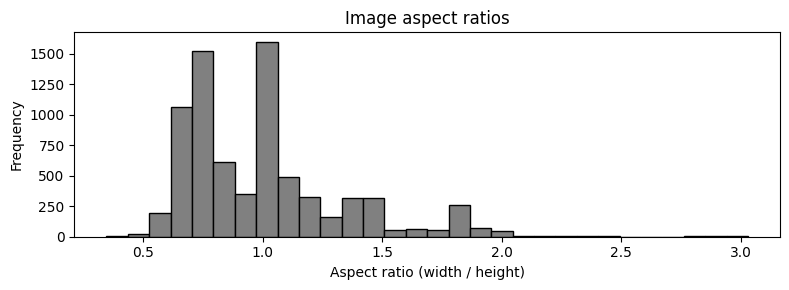

In [7]:
# Calculate and plot aspect ratios
aspect_ratios = [w / h for w, h in zip(widths, heights)]

fig, ax = plt.subplots(figsize=(8, 3))

ax.set_title('Image aspect ratios')
ax.hist(aspect_ratios, bins=30, color='grey', edgecolor='black')
ax.set_xlabel('Aspect ratio (width / height)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Found 90 images with aspect ratio <= 0.5 or >= 2.0



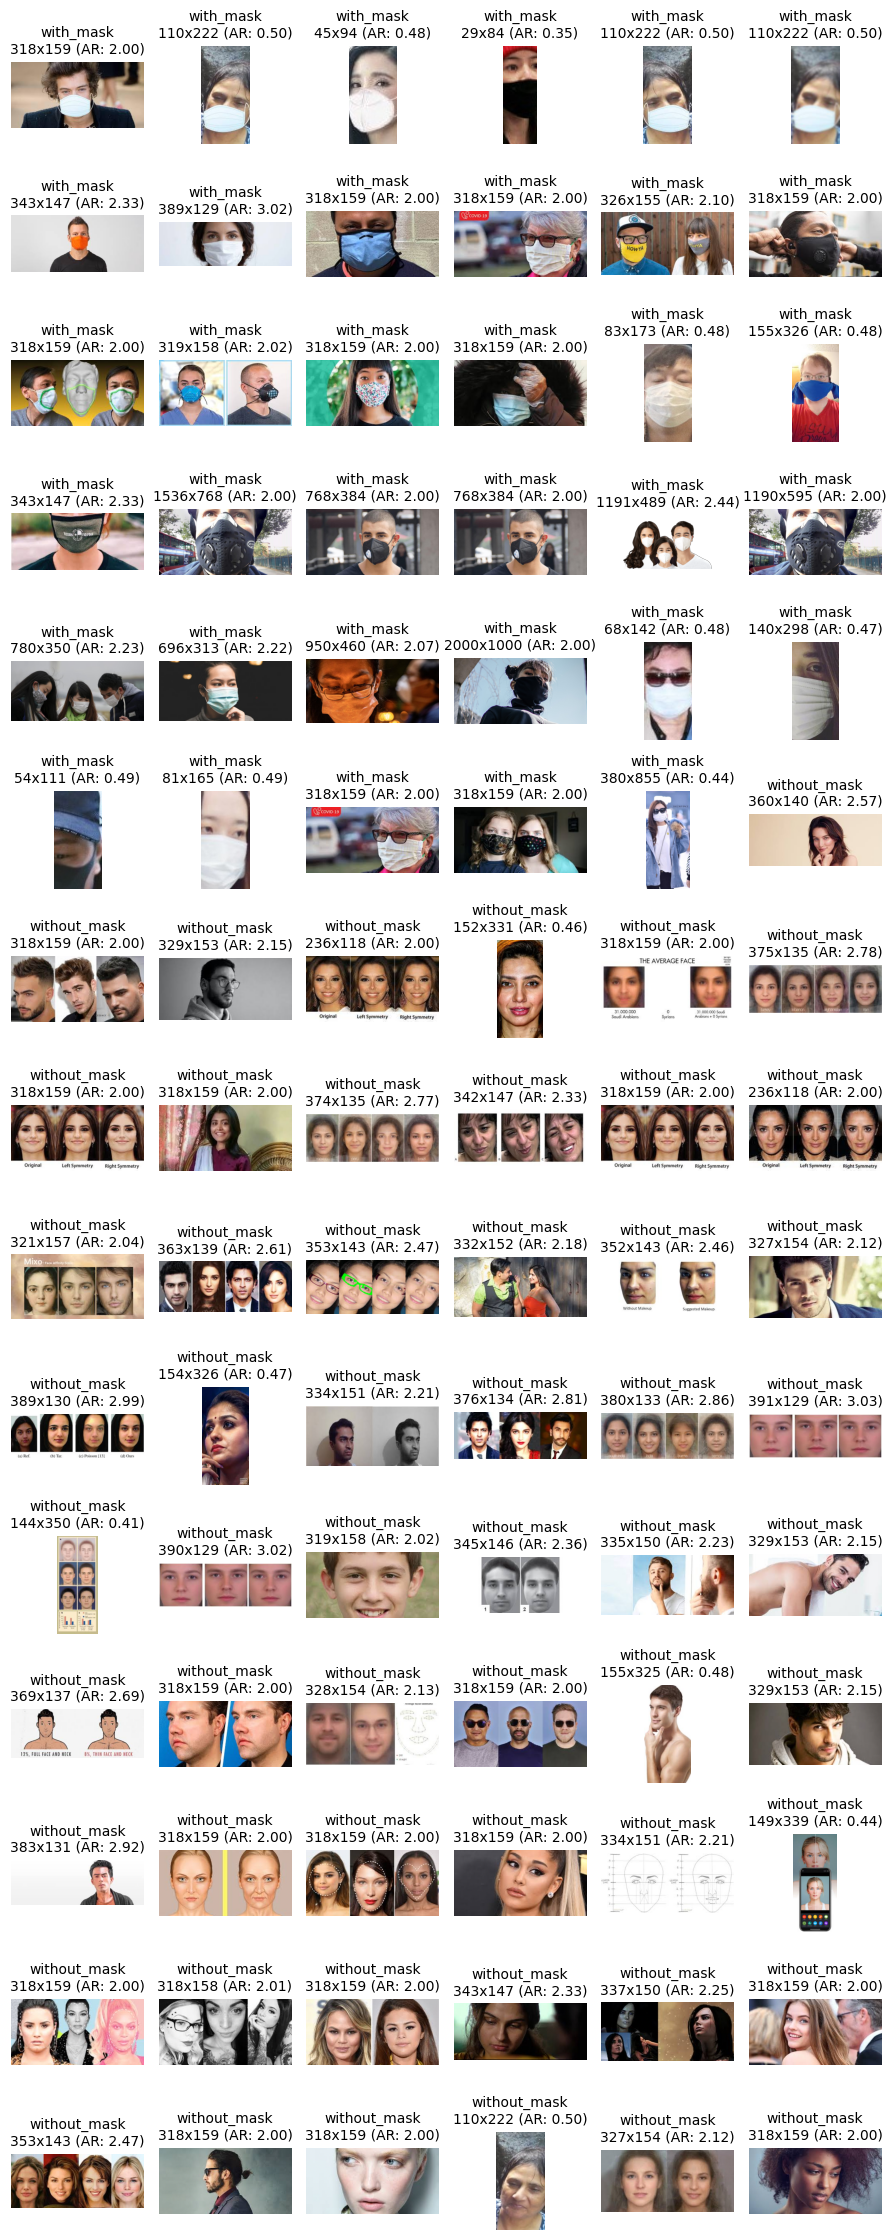

In [8]:
# Find and display images with extreme aspect ratios
extreme_aspect_images = []

for idx, (img_path, label) in enumerate(info_dataset.imgs):
    ratio = aspect_ratios[idx]
    if ratio <= 0.5 or ratio >= 2.0:
        extreme_aspect_images.append((img_path, label, widths[idx], heights[idx], ratio))

print(f'Found {len(extreme_aspect_images)} images with aspect ratio <= 0.5 or >= 2.0\n')

if extreme_aspect_images:
    plot_image_grid(
        extreme_aspect_images,
        title_func=lambda data: f'{class_names[data[1]]}\n{data[2]}x{data[3]} (AR: {data[4]:.2f})'
    )
else:
    print('No images found with extreme aspect ratios')

### 2.2. Build tensors

In [9]:
# Data preprocessing:
# 1. Convert indexed images to RGB (some are RGBA)
# 2. Resize images to 128x128
# 3. Convert images to tensors
# 4. Normalize images

target_size = (128, 128)

transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create image dataset
dataset = datasets.ImageFolder(
    root='../data',
    transform=transform
)

In [10]:
# Create tensors and preload to GPU
# Note: We suppress the PIL transparency warning here because our convert_to_rgb 
# function already handles it correctly by converting palette images to RGBA first,
# then to RGB. The warning is informational, not an error.
with warnings.catch_warnings():
    
    warnings.filterwarnings('ignore', message='Palette images with Transparency')
    
    X = torch.stack([img for img, _ in dataset]).to(device)
    y = torch.tensor([label for _, label in dataset]).to(device)

print(f'Image tensor shape: {X.shape}')
print(f'Label tensor shape: {y.shape}')

Image tensor shape: torch.Size([7553, 3, 128, 128])
Label tensor shape: torch.Size([7553])


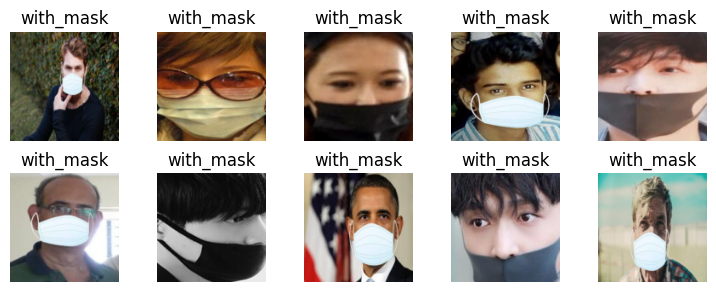

In [11]:
# Plot first 10 RGB images from the training dataset
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*1.5, nrows*1.5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img, label = dataset[i]
    
    # Unnormalize and transpose for plotting
    img = img * 0.5 + 0.5
    img = img.numpy().transpose(1, 2, 0)  # Change from CxHxW to HxWxC
    ax.set_title(class_names[label])
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

### 2.3. Training, validation, testing split

In [12]:
# Split data into train, validation, and test sets
# Both validation and test sets will have 1500 images each
val_size = 1500
test_size = 1500
train_size = len(X) - val_size - test_size

indices = torch.randperm(len(X))

X_train = X[indices[:train_size]]
y_train = y[indices[:train_size]]
X_val = X[indices[train_size:train_size + val_size]]
y_val = y[indices[train_size:train_size + val_size]]
X_test = X[indices[train_size + val_size:]]
y_test = y[indices[train_size + val_size:]]

print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 4553
Validation set size: 1500
Test set size: 1500


### 2.4. Data augmentation

In [13]:
# Define augmentation transforms (applied to already normalized tensors)
augmentation_transforms = nn.Sequential(
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=0.1),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)], p=0.1),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
    transforms.RandomApply([transforms.Lambda(lambda x: -x)], p=0.1),  # Color inversion (negative)
    transforms.RandomApply([transforms.Lambda(lambda x: x[:, torch.randperm(3)])], p=0.3),  # Shuffle RGB channels
    transforms.RandomApply([transforms.Lambda(lambda x: x[:, 0].unsqueeze(1).repeat(1, 3, 1, 1))], p=0.1),  # Duplicate R channel
    transforms.RandomApply([transforms.Lambda(lambda x: x[:, 1].unsqueeze(1).repeat(1, 3, 1, 1))], p=0.1),  # Duplicate G channel
    transforms.RandomApply([transforms.Lambda(lambda x: x[:, 2].unsqueeze(1).repeat(1, 3, 1, 1))], p=0.1),  # Duplicate B channel
)

In [14]:
# Generate augmented training data using the generate_augmented_data function
# Keep augmented data on CPU to save GPU memory, move batches to GPU during training
X_train_final, y_train_final = generate_augmented_data(
    X_train=X_train,
    y_train=y_train,
    augmentation_transforms=augmentation_transforms,
    augmentations_per_image=augmentations_per_image,
    save_path=augmented_data_path,
    force_reaugment=force_reaugment
)

Loading pre-generated augmented data from ../data/augmented_train_data.pt...

Loaded augmented training set:
  Total size: 95613
  Original: 4553
  Added: 91060
  Memory location: cpu
  Augmentation factor: 21.0x


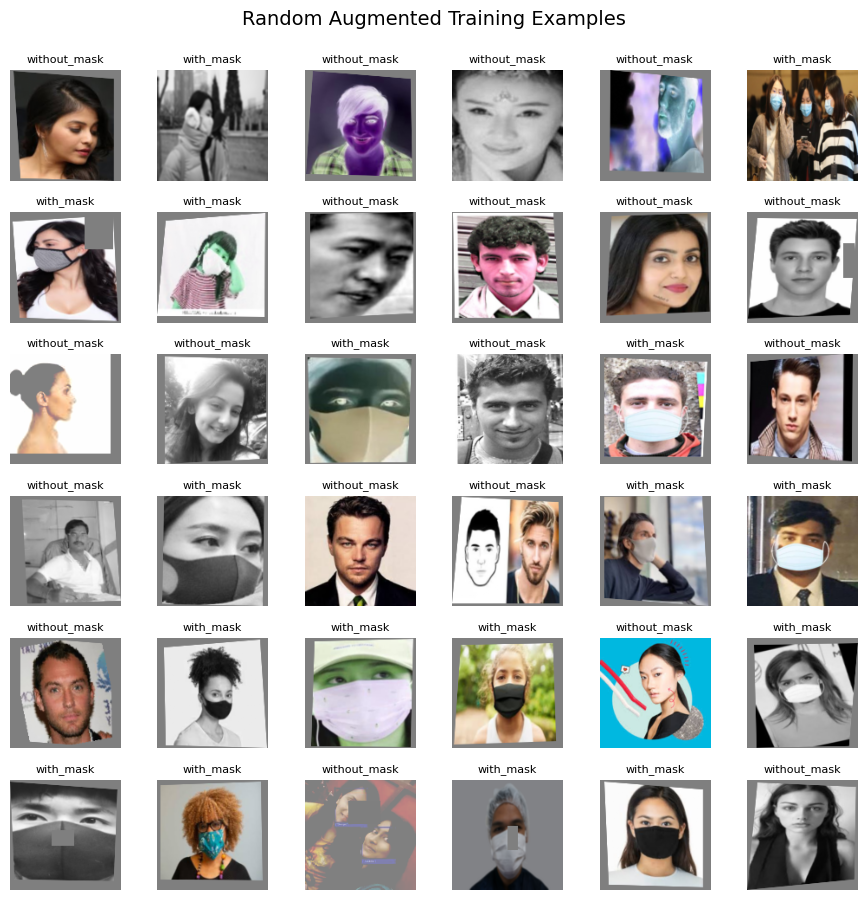

In [15]:
# Display random augmented examples
ncols = 6
nrows = 6
n_samples = ncols * nrows

# Sample random indices
random_indices = torch.randperm(len(X_train_final))[:n_samples]

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*1.5, nrows*1.5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    idx = random_indices[i]
    img = X_train_final[idx]
    label = y_train_final[idx]
    
    # Unnormalize and transpose for plotting
    img = img * 0.5 + 0.5
    img = img.numpy().transpose(1, 2, 0)  # Change from CxHxW to HxWxC
    
    # Clip values to [0, 1] range (some augmentations might create values outside this range)
    img = np.clip(img, 0, 1)
    
    ax.set_title(class_names[label], fontsize=8)
    ax.imshow(img)
    ax.axis('off')

plt.suptitle('Random Augmented Training Examples', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

### 2.5. Create DataLoader for training & evaluation

In [16]:
# Create TensorDatasets for train, validation, and test sets
# Training data is on CPU, validation/test data remains on GPU
train_tensor_dataset = torch.utils.data.TensorDataset(X_train_final, y_train_final)
val_tensor_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_tensor_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Finally, create DataLoaders
# Training data will be moved to GPU batch-by-batch during training
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size)
test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size)

print(f'X_train_final shape: {X_train_final.shape}')
print(f'y_train_final shape: {y_train_final.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

print(f'\nTraining data on: {X_train_final.device}')
print(f'Validation data on: {X_val.device}')
print(f'Test data on: {X_test.device}')

X_train_final shape: torch.Size([95613, 3, 128, 128])
y_train_final shape: torch.Size([95613])
X_val shape: torch.Size([1500, 3, 128, 128])
y_val shape: torch.Size([1500])
X_test shape: torch.Size([1500, 3, 128, 128])
y_test shape: torch.Size([1500])

Training data on: cpu
Validation data on: cuda:0
Test data on: cuda:0


In [17]:
def create_model(device):
    """Create the CNN model architecture for face mask detection.
    
    Args:
        device: The device to place the model on (CPU or CUDA).
        
    Returns:
        A PyTorch Sequential model.
    """
    model = nn.Sequential(

        # Conv block: RGB input (3 channels)
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.25),

        # Conv block
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.25),

        # Conv block
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.25),

        # Conv block
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.25),
        
        # Classifier
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 2)  # Binary classification: 2 outputs for CrossEntropyLoss

    ).to(device)
    
    return model

## 3. Build model

In [18]:
# Create the model
model = create_model(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print(f'\nTotal parameters: {trainable_params}')

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.25, inplace=False)
  (16): Conv2d(64, 128, kernel_size=(3, 3), str

## 4. Train model

In [19]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_base_lr)

# Cyclical learning rate scheduler (steps per batch)
cyclic_scheduler = optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=initial_base_lr,
    max_lr=initial_max_lr,
    step_size_up=step_size_up
)

In [20]:
%%time

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    cyclic_scheduler=cyclic_scheduler,
    lr_schedule={
        'initial_base_lr': initial_base_lr,
        'initial_max_lr': initial_max_lr,
        'final_base_lr': final_base_lr,
        'final_max_lr': final_max_lr,
        'schedule_epochs': lr_schedule_epochs
    },
    epochs=epochs,
    early_stopping_patience=early_stopping_patience,
    print_every=print_every,
    device=device
)

print()

Epoch   1/50 - loss: 0.3011 - acc: 86.56% - val_loss: 0.0689 - val_acc: 97.53% - lr: 1.00e-02 (base: 9.00e-05, max: 9.00e-03)
Epoch   5/50 - loss: 0.0340 - acc: 98.71% - val_loss: 0.0397 - val_acc: 98.87% - lr: 5.99e-03 (base: 5.00e-05, max: 5.00e-03)
Epoch  10/50 - loss: 0.0069 - acc: 99.76% - val_loss: 0.0239 - val_acc: 99.80% - lr: 1.34e-05 (base: 9.90e-08, max: 1.00e-07)

Early stopping at epoch 12
Best val_loss: 0.0136 at epoch 2
Restored best model weights

CPU times: user 39min 40s, sys: 3.88 s, total: 39min 44s
Wall time: 20min 27s


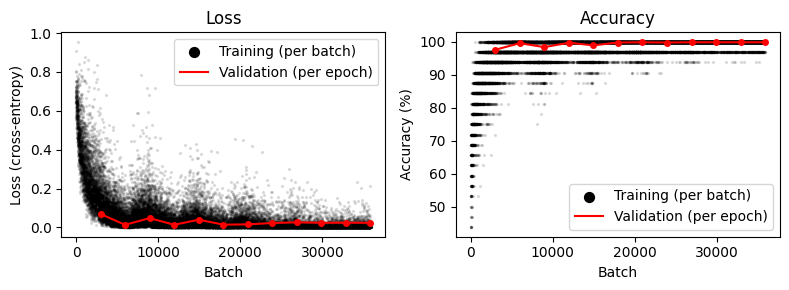

Total training batches: 35,856
Batches per epoch: 2,987
Epochs completed: 12


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Calculate x-positions for validation metrics (end of each epoch)
val_x_positions = [(i + 1) * batches_per_epoch for i in range(len(history['val_loss']))]

# Plot batch-level training metrics
axes[0].set_title('Loss')
axes[0].scatter(
    range(len(history['batch_train_loss'])), history['batch_train_loss'],
    c='black', s=2, alpha=0.1,
    label='Training (per batch)'
)
axes[0].plot(
    val_x_positions, history['val_loss'], 
    marker='o', markersize=4, color='red',
    label='Validation (per epoch)'
)
axes[0].set_xlabel('Batch')
axes[0].set_ylabel('Loss (cross-entropy)')
legend_0 = axes[0].legend(loc='best', markerscale=5)

# Set alpha=1 for legend markers and remove marker from validation line in legend
for i, lh in enumerate(legend_0.legend_handles):
    lh.set_alpha(1)
    if i == 1:  # Validation line (second legend entry)
        lh.set_marker('')

axes[1].set_title('Accuracy')
axes[1].scatter(
    range(len(history['batch_train_accuracy'])), history['batch_train_accuracy'],
    c='black', s=2, alpha=0.1,
    label='Training (per batch)'
)
axes[1].plot(
    val_x_positions, history['val_accuracy'],
    marker='o', markersize=4, color='red',
    label='Validation (per epoch)'
)
axes[1].set_xlabel('Batch')
axes[1].set_ylabel('Accuracy (%)')
legend_1 = axes[1].legend(loc='best', markerscale=5)

# Set alpha=1 for legend markers and remove marker from validation line in legend
for i, lh in enumerate(legend_1.legend_handles):
    lh.set_alpha(1)
    if i == 1:  # Validation line (second legend entry)
        lh.set_marker('')

plt.tight_layout()
plt.show()

print(f'Total training batches: {len(history["batch_train_loss"]):,}')
print(f'Batches per epoch: {batches_per_epoch:,}')
print(f'Epochs completed: {len(history["train_loss"])}')

## 5. Evaluate the model on test set

In [22]:
# Evaluate model on test set using the evaluate function
test_loss, test_acc = evaluate(model, test_loader, criterion, device=None)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')

Test Loss: 0.0075
Test Accuracy: 99.80%


In [23]:
# Get predictions and probabilities for detailed analysis
model.eval()

y_true = []
y_pred = []
y_proba = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_proba.extend(probabilities[:, 1].cpu().numpy())  # Probability of positive class

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_proba = np.array(y_proba)

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score

precision_val = precision_score(y_true, y_pred, pos_label=1)
recall_val = recall_score(y_true, y_pred, pos_label=1)

# Calculate confusion matrix components
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate false positive rate and false negative rate
fpr_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

print(f'\nAdditional Metrics:')
print(f'Precision: {precision_val:.4f}')
print(f'Recall: {recall_val:.4f}')
print(f'False Positive Rate: {fpr_rate:.4f}')
print(f'False Negative Rate: {fnr_rate:.4f}')


Additional Metrics:
Precision: 0.9987
Recall: 0.9975
False Positive Rate: 0.0014
False Negative Rate: 0.0025


### 5.1. Predicted probability distributions

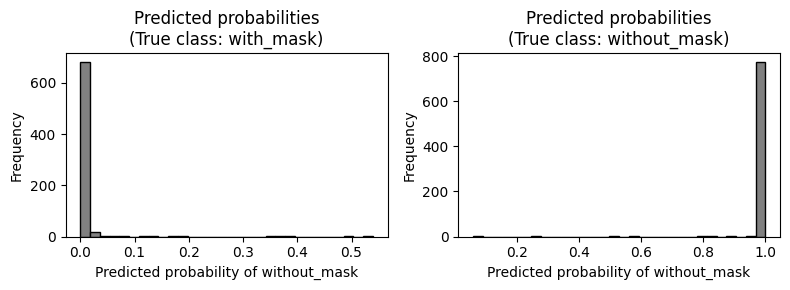

In [24]:
# Plot histograms of predicted probabilities for each class
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Histogram for images with masks (class 0)
mask_proba = y_proba[y_true == 0]

axes[0].set_title('Predicted probabilities\n(True class: with_mask)')
axes[0].hist(mask_proba, bins=30, color='grey', edgecolor='black')
axes[0].set_xlabel('Predicted probability of without_mask')
axes[0].set_ylabel('Frequency')

# Histogram for images without masks (class 1)
no_mask_proba = y_proba[y_true == 1]

axes[1].set_title('Predicted probabilities\n(True class: without_mask)')
axes[1].hist(no_mask_proba, bins=30, color='grey', edgecolor='black')
axes[1].set_xlabel('Predicted probability of without_mask')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 5.2. Confusion matrix

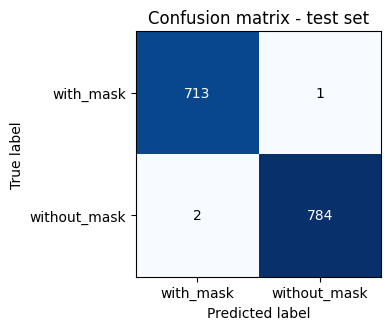

In [25]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))

ax.set_title('Confusion matrix - test set')
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Add text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(
            j, i, cm[i, j], ha='center', va='center', 
            color='white' if cm[i, j] > cm.max() / 2 else 'black', 
        )

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.tight_layout()
plt.show()

### 5.3. ROC and PR curves

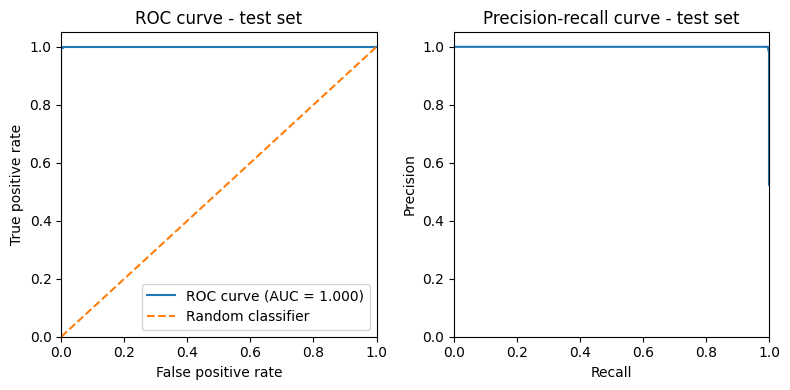

ROC AUC Score: 1.0000
Average Precision Score: 1.0000


In [26]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and average precision
precision, recall, _ = precision_recall_curve(y_true, y_proba)
avg_precision = average_precision_score(y_true, y_proba)

# Plot both curves
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# ROC Curve
axes[0].set_title('ROC curve - test set')
axes[0].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False positive rate')
axes[0].set_ylabel('True positive rate')
axes[0].legend(loc='lower right')

# Precision-Recall Curve
axes[1].set_title('Precision-recall curve - test set')
axes[1].plot(
    recall, precision,
    label=f'PR curve (AP = {avg_precision:.3f})'
)

axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')

plt.tight_layout()
plt.show()

print(f'ROC AUC Score: {roc_auc:.4f}')
print(f'Average Precision Score: {avg_precision:.4f}')

### 5.4. Misclassified examples

In [27]:
# Find false positives and false negatives from test set
# We need to map back to the original dataset indices

# Get indices of test set in original dataset
test_indices = indices[train_size + val_size:].cpu().numpy()

# Find misclassified examples
false_positive_data = []  # Predicted without_mask, actually with_mask (predicted 1, true 0)
false_negative_data = []  # Predicted with_mask, actually without_mask (predicted 0, true 1)

for i, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
    if true_label != pred_label:

        # Get original dataset index
        orig_idx = test_indices[i]
        img_path, label = dataset.imgs[orig_idx]
        
        # Get the test image for display
        test_img = X_test[i]
        
        if true_label == 0 and pred_label == 1:

            # False positive: actually with_mask, predicted without_mask
            false_positive_data.append((img_path, label, y_proba[i]))

        elif true_label == 1 and pred_label == 0:

            # False negative: actually without_mask, predicted with_mask
            false_negative_data.append((img_path, label, y_proba[i]))

print(f'False Positives: {len(false_positive_data)} (predicted without_mask, actually with_mask)')
print(f'False Negatives: {len(false_negative_data)} (predicted with_mask, actually without_mask)')

False Positives: 1 (predicted without_mask, actually with_mask)
False Negatives: 2 (predicted with_mask, actually without_mask)


False Positives: 1


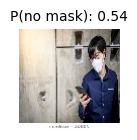

In [28]:
# Display false positives
print(f'False Positives: {len(false_positive_data)}')

if false_positive_data:
    plot_image_grid(
        false_positive_data,
        title_func=lambda data: f'P(no mask): {data[2]:.2f}',
        max_cols=6
    )
else:
    print('No false positives!')

False Negatives: 2


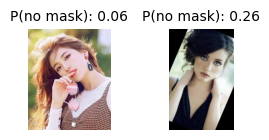

In [29]:
# Display false negatives
print(f'False Negatives: {len(false_negative_data)}')

if false_negative_data:
    plot_image_grid(
        false_negative_data,
        title_func=lambda data: f'P(no mask): {data[2]:.2f}',
        max_cols=6
    )
else:
    print('No false negatives!')

## 6. Train final production model

Train a final model using all available data (train + validation + test) with augmentations to maximize performance for deployment.

In [30]:
# Combine all data for final production model training
X_all = torch.cat([X_train, X_val, X_test], dim=0)
y_all = torch.cat([y_train, y_val, y_test], dim=0)

print(f'Total dataset size: {len(X_all)}')
print(f'Class distribution:')

for i, class_name in enumerate(class_names):
    count = (y_all == i).sum().item()
    print(f'  {class_name}: {count} ({count/len(y_all)*100:.1f}%)')

Total dataset size: 7553
Class distribution:
  with_mask: 3725 (49.3%)
  without_mask: 3828 (50.7%)


In [31]:
# Generate augmented data for the full dataset
print('Generating augmented data for full dataset...\n')

X_all_final, y_all_final = generate_augmented_data(
    X_train=X_all,
    y_train=y_all,
    augmentation_transforms=augmentation_transforms,
    augmentations_per_image=augmentations_per_image,
    save_path='../data/augmented_all_data.pt',
    force_reaugment=force_reaugment
)

Generating augmented data for full dataset...

No saved augmented data found. Generating augmentations...
Creating augmentation batch 1/20...
Creating augmentation batch 2/20...
Creating augmentation batch 3/20...
Creating augmentation batch 4/20...
Creating augmentation batch 5/20...
Creating augmentation batch 6/20...
Creating augmentation batch 7/20...
Creating augmentation batch 8/20...
Creating augmentation batch 9/20...
Creating augmentation batch 10/20...
Creating augmentation batch 11/20...
Creating augmentation batch 12/20...
Creating augmentation batch 13/20...
Creating augmentation batch 14/20...
Creating augmentation batch 15/20...
Creating augmentation batch 16/20...
Creating augmentation batch 17/20...
Creating augmentation batch 18/20...
Creating augmentation batch 19/20...
Creating augmentation batch 20/20...

Augmented training set size: 158613
  Added: 151060
  Original: 7553
  Memory location: cpu
  Augmentation factor: 21.0x

Saving augmented data to ../data/augment

In [32]:
# Create DataLoader for full augmented dataset
all_tensor_dataset = torch.utils.data.TensorDataset(X_all_final, y_all_final)
all_loader = DataLoader(all_tensor_dataset, batch_size=batch_size, shuffle=True)

augmented_all_size = len(X_all_final)
batches_per_epoch_final = augmented_all_size // batch_size

print(f'Augmented full dataset size: {augmented_all_size:,}')
print(f'Batches per epoch: {batches_per_epoch_final:,}')

Augmented full dataset size: 158,613
Batches per epoch: 4,956


In [33]:
# Create a fresh model for production training
production_model = create_model(device)

production_params = sum(p.numel() for p in production_model.parameters() if p.requires_grad)
print(f'Production model parameters: {production_params:,}')

Production model parameters: 1,207,330


In [34]:
# Setup training for production model
production_criterion = nn.CrossEntropyLoss()
production_optimizer = optim.Adam(production_model.parameters(), lr=initial_base_lr)

# Adjust step_size_up for new dataset size
production_step_size_up = batches_per_epoch_final * 2  # 2 epochs per half cycle

production_cyclic_scheduler = optim.lr_scheduler.CyclicLR(
    production_optimizer,
    base_lr=initial_base_lr,
    max_lr=initial_max_lr,
    step_size_up=production_step_size_up,
    mode='triangular',
    cycle_momentum=False
)

print(f'Production training configuration:')
print(f'  Step size up: {production_step_size_up:,} iterations ({production_step_size_up / batches_per_epoch_final:.1f} epochs)')
print(f'  Full cycle: {2 * production_step_size_up:,} iterations ({2 * production_step_size_up / batches_per_epoch_final:.1f} epochs)')

Production training configuration:
  Step size up: 9,912 iterations (2.0 epochs)
  Full cycle: 19,824 iterations (4.0 epochs)


In [35]:
%%time

production_epochs = 30  # Train for fixed number of epochs

# Train production model using train_model function with no validation data
production_history = train_model(
    model=production_model,
    train_loader=all_loader,
    val_loader=None,  # No validation set for production model
    criterion=production_criterion,
    optimizer=production_optimizer,
    cyclic_scheduler=production_cyclic_scheduler,
    epochs=production_epochs,
    print_every=5,
    device=device
)

print('\nProduction model training complete!')

Epoch   1/30 - loss: 0.2640 - acc: 88.25% - lr: 5.05e-03 (base: 1.00e-04, max: 1.00e-02)
Epoch   5/30 - loss: 0.0179 - acc: 99.33% - lr: 5.05e-03 (base: 1.00e-04, max: 1.00e-02)
Epoch  10/30 - loss: 0.0248 - acc: 99.13% - lr: 9.99e-03 (base: 1.00e-04, max: 1.00e-02)
Epoch  15/30 - loss: 0.0188 - acc: 99.36% - lr: 5.04e-03 (base: 1.00e-04, max: 1.00e-02)
Epoch  20/30 - loss: 0.0056 - acc: 99.79% - lr: 1.20e-04 (base: 1.00e-04, max: 1.00e-02)
Epoch  25/30 - loss: 0.0047 - acc: 99.84% - lr: 5.07e-03 (base: 1.00e-04, max: 1.00e-02)
Epoch  30/30 - loss: 0.0118 - acc: 99.62% - lr: 9.97e-03 (base: 1.00e-04, max: 1.00e-02)

Production model training complete!
CPU times: user 2h 44min 33s, sys: 17.9 s, total: 2h 44min 51s
Wall time: 1h 24min 31s


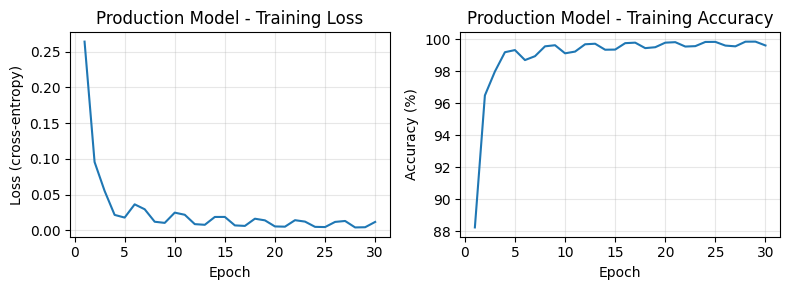

Final training loss: 0.0118
Final training accuracy: 99.62%


In [36]:
# Plot production model training curves
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].set_title('Production Model - Training Loss')
axes[0].plot(range(1, len(production_history['train_loss']) + 1), production_history['train_loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (cross-entropy)')
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Production Model - Training Accuracy')
axes[1].plot(range(1, len(production_history['train_accuracy']) + 1), production_history['train_accuracy'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Final training loss: {production_history["train_loss"][-1]:.4f}')
print(f'Final training accuracy: {production_history["train_accuracy"][-1]:.2f}%')

In [37]:
# Save production model for deployment
production_model.eval()
save_path = '../models/face_mask_detector_production.pth'

# Save only what's needed for deployment
torch.save({
    'model_state_dict': production_model.state_dict(),
    'class_names': class_names,
    'target_size': target_size,
    'normalization_mean': (0.5, 0.5, 0.5),
    'normalization_std': (0.5, 0.5, 0.5)
}, save_path)

print(f'Production model saved: {save_path}')
print(f'\nModel ready for deployment!')
print(f'  - Model parameters: {production_params:,}')

Production model saved: ../models/face_mask_detector_production.pth

Model ready for deployment!
  - Model parameters: 1,207,330
